In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from siphon.catalog import TDSCatalog
import metpy.calc as mpcalc
from metpy.units import units
from scipy.ndimage import gaussian_filter
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from wrf import vinterp, to_np, getvar, CoordPair, vertcross, get_cartopy, latlon_coords


C:\Users\Tony\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
directions = {'North': 55, 
            'East': 250, 
            'South': 20, 
            'West': 200}
g = 9.81 # units: m/s^2

In [3]:
# Define the URLs for the datasets of the variables we want to download (temperature, geopotential height, humidity, v-wind, u-wind)
urls = {
    'temperature_pl': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_130_t.ll025sc.2019022400_2019022423.nc',
    'geopotential_pl': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_129_z.ll025sc.2019022400_2019022423.nc',
    'mslp_sfc': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_151_msl.ll025sc.2019020100_2019022823.nc',    
    'humidity_pl': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_133_q.ll025sc.2019022400_2019022423.nc',
    'v_wind_pl': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_132_v.ll025uv.2019022400_2019022423.nc',
    'u_wind_pl': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_131_u.ll025uv.2019022400_2019022423.nc',
    'pv': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_060_pv.ll025sc.2019022400_2019022423.nc',
    'u_wind_sfc': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_131_u10n.ll025sc.2019020100_2019022823.nc',
    'v_wind_sfc': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_132_v10n.ll025sc.2019020100_2019022823.nc'
}

# Load the datasets from the URLs
datasets = {}
for var, url in urls.items():
    tds_catalog = TDSCatalog(url)
    ds_url = tds_catalog.datasets[0].access_urls['OPENDAP']
    ds = xr.open_dataset(ds_url).metpy.parse_cf()
    datasets[var] = ds

# Merge all pressure level datasets into a single Xarray Dataset
ds_pl = xr.merge([datasets['temperature_pl'], datasets['geopotential_pl'], datasets['humidity_pl'], datasets['v_wind_pl'], datasets['u_wind_pl'], datasets['pv']])

# Merge all surface datasets into a single Xarray Dataset
ds_sfc = xr.merge([datasets['mslp_sfc'], datasets['v_wind_sfc'], datasets['u_wind_sfc']])

C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_130_t.ll025sc.2019022400_2019022423.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_130_t.ll025sc.2019022400_2019022423.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,
C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_129_z.ll025sc.2019022400_2019022423.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g

In [4]:
ds_pl_sliced = ds_pl.isel(time=0)
ds_sfc_sliced = ds_sfc.isel(time=0)

# Slice the dataset to get the data for the region of interest
ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))
ds_sfc_sliced = ds_sfc_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))

# Slice the dataset to get the data for the pressure level at 250 hPa
u_250 = ds_pl_sliced['U'].sel(level=250) # units: m/s
v_250 = ds_pl_sliced['V'].sel(level=250) # units: m/s
z_250 = ds_pl_sliced['Z'].sel(level=250) / g # units: m
pressure_levels = u_250.level * 100 # units: Pa

# Slice the dataset to get the mslp
mslp = ds_sfc_sliced['MSL'] / 100 # units: hPa

# Calculate the wind speed at 250 hPa
wind_speed_250 = np.sqrt(u_250**2 + v_250**2)

# Get the time of the current time step and create a pandas DatetimeIndex
time = ds_pl_sliced.time.values
int_datetime_index = pd.DatetimeIndex([time])


In [ ]:
t = ds_pl_sliced['T'].sel(level=slice(150, 1000)) # units: K
pressure_levels = t['level'] # units: hPa
theta = mpcalc.potential_temperature(pressure_levels, t) # units: K

In [9]:
t = ds_pl_sliced['T'].sel(level=slice(150, 1000)) # units: K
pressure_levels = t['level'] # units: hPa

In [11]:
theta = mpcalc.potential_temperature(pressure_levels, t) # units: K

In [19]:
theta

<xarray.DataArray (level: 25, latitude: 141, longitude: 201)>
<Quantity([[[368.96759161 368.97430841 368.9482808  ... 377.07729016 377.18727779
   377.28383181]
  [369.55615136 369.55027416 369.55363256 ... 377.35519783 377.43915785
   377.50968427]
  [369.90038746 369.87435985 369.88947265 ... 377.59028589 377.64402031
   377.68600032]
  ...
  [362.34650425 362.26422343 362.18614061 ... 366.38750012 366.46726214
   366.49161055]
  [361.94853375 361.88388453 361.82427291 ... 366.21286328 366.3068985
   366.32704891]
  [361.59086405 361.54552564 361.50354563 ... 366.03402843 366.12974285
   366.14485566]]

 [[347.07863738 346.64800203 346.20611874 ... 360.56812914 360.68864276
   360.81558378]
  [347.71655617 347.3518016  346.97579909 ... 360.63240307 360.76095094
   360.89753305]
  [348.19861067 347.89652318 347.57836721 ... 360.73524137 360.87503717
   361.01804667]
...
  [294.62493052 294.78034757 294.89445123 ... 292.15399611 292.57499927
   293.01764277]
  [294.77444566 294.89641854 295.03806446 ... 292.7658278  293.12781182
   293.44454784]
  [294.94953576 295.04396637 295.1875796  ... 293.35208453 293.59603029
   293.75341464]]

 [[276.55300903 276.47097778 276.40066528 ... 257.02761841 256.84988403
   256.73855591]
  [276.75613403 276.63894653 276.54714966 ... 257.65261841 257.48660278
   257.30886841]
  [276.98855591 276.88699341 276.79519653 ... 258.10769653 257.99246216
   257.79324341]
  ...
  [294.65066528 294.79714966 294.89089966 ... 292.16433716 292.60183716
   293.00418091]
  [294.78152466 294.91629028 295.02761841 ... 292.71121216 293.11550903
   293.42410278]
  [294.94754028 295.06277466 295.18386841 ... 293.31082153 293.55496216
   293.73269653]]], 'kelvin')>
Coordinates:
    time       datetime64[ns] 2019-02-24
  * latitude   (latitude) float64 55.0 54.75 54.5 54.25 ... 20.5 20.25 20.0
  * level      (level) float64 150.0 175.0 200.0 225.0 ... 950.0 975.0 1e+03
  * longitude  (longitude) float64 200.0 200.2 200.5 200.8 ... 249.5 249.8 250.0
    metpy_crs  object Projection: latitude_longitude

In [21]:
pressure_levels

<xarray.DataArray 'level' (level: 25)>
array([ 150.,  175.,  200.,  225.,  250.,  300.,  350.,  400.,  450.,  500.,
        550.,  600.,  650.,  700.,  750.,  775.,  800.,  825.,  850.,  875.,
        900.,  925.,  950.,  975., 1000.])
Coordinates:
    time       datetime64[ns] 2019-02-24
  * level      (level) float64 150.0 175.0 200.0 225.0 ... 950.0 975.0 1e+03
    metpy_crs  object Projection: latitude_longitude
Attributes:
    long_name:        pressure level
    short_name:       plev
    units:            hPa
    alternate_units:  millibar
    _ChunkSizes:      37
    _metpy_axis:      vertical

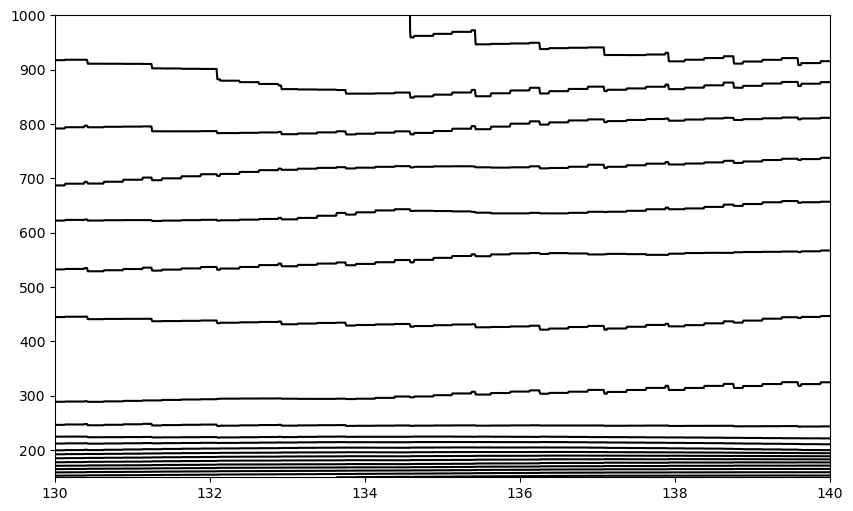

In [24]:
start_point = (45.5, 360-140)
end_point = (42.5, 360-130)
n = 1000

lat_values = np.linspace(start_point[0], end_point[0])
lon_values = np.linspace(start_point[1], end_point[1])
x = xr.DataArray(np.linspace(start_point[1],end_point[1],n), dims='Lat_Lon')
y = xr.DataArray(np.linspace(start_point[0],end_point[0],n), dims='Lat_Lon')
ds_cross = ds_pl_sliced.interp(longitude=x, latitude=y, method='nearest')

t = ds_cross['T'].sel(level=slice(150, 1000)) # units: K
pressure_levels = t['level'] # units: hPa
theta = mpcalc.potential_temperature(pressure_levels, t) # units: K




In [30]:
list(pressure_levels.values)

[150.0,
 175.0,
 200.0,
 225.0,
 250.0,
 300.0,
 350.0,
 400.0,
 450.0,
 500.0,
 550.0,
 600.0,
 650.0,
 700.0,
 750.0,
 775.0,
 800.0,
 825.0,
 850.0,
 875.0,
 900.0,
 925.0,
 950.0,
 975.0,
 1000.0]

(1000, 150)

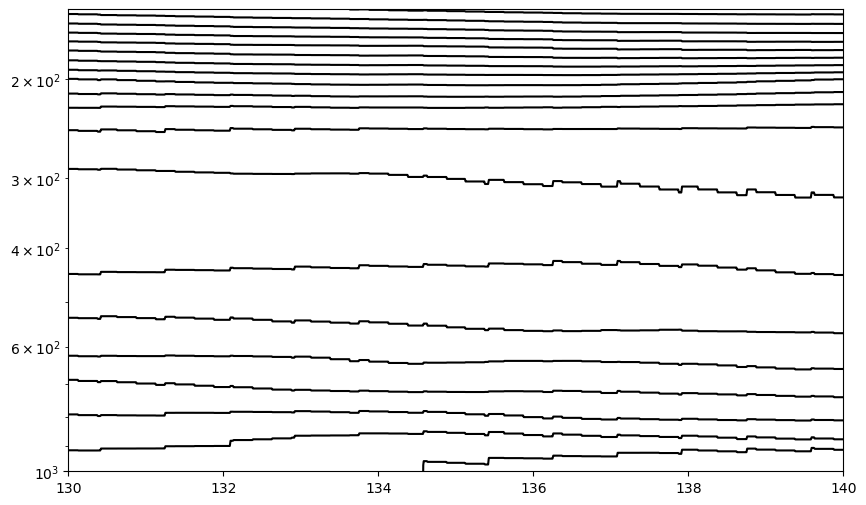

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the cross section
ax.contour(360 - ds_cross['longitude'], pressure_levels, theta, colors='black', levels=np.arange(250, 450, 5))
ax.set_yticks(pressure_levels)
ax.set_yticklabels(list(pressure_levels.values))
ax.set_yscale('log')
plt.ylim(1000, 150)

In [12]:
theta

<xarray.DataArray (level: 25, latitude: 141, longitude: 201)>
<Quantity([[[368.96759161 368.97430841 368.9482808  ... 377.07729016 377.18727779
   377.28383181]
  [369.55615136 369.55027416 369.55363256 ... 377.35519783 377.43915785
   377.50968427]
  [369.90038746 369.87435985 369.88947265 ... 377.59028589 377.64402031
   377.68600032]
  ...
  [362.34650425 362.26422343 362.18614061 ... 366.38750012 366.46726214
   366.49161055]
  [361.94853375 361.88388453 361.82427291 ... 366.21286328 366.3068985
   366.32704891]
  [361.59086405 361.54552564 361.50354563 ... 366.03402843 366.12974285
   366.14485566]]

 [[347.07863738 346.64800203 346.20611874 ... 360.56812914 360.68864276
   360.81558378]
  [347.71655617 347.3518016  346.97579909 ... 360.63240307 360.76095094
   360.89753305]
  [348.19861067 347.89652318 347.57836721 ... 360.73524137 360.87503717
   361.01804667]
...
  [294.62493052 294.78034757 294.89445123 ... 292.15399611 292.57499927
   293.01764277]
  [294.77444566 294.89641854 295.03806446 ... 292.7658278  293.12781182
   293.44454784]
  [294.94953576 295.04396637 295.1875796  ... 293.35208453 293.59603029
   293.75341464]]

 [[276.55300903 276.47097778 276.40066528 ... 257.02761841 256.84988403
   256.73855591]
  [276.75613403 276.63894653 276.54714966 ... 257.65261841 257.48660278
   257.30886841]
  [276.98855591 276.88699341 276.79519653 ... 258.10769653 257.99246216
   257.79324341]
  ...
  [294.65066528 294.79714966 294.89089966 ... 292.16433716 292.60183716
   293.00418091]
  [294.78152466 294.91629028 295.02761841 ... 292.71121216 293.11550903
   293.42410278]
  [294.94754028 295.06277466 295.18386841 ... 293.31082153 293.55496216
   293.73269653]]], 'kelvin')>
Coordinates:
    time       datetime64[ns] 2019-02-24
  * latitude   (latitude) float64 55.0 54.75 54.5 54.25 ... 20.5 20.25 20.0
  * level      (level) float64 150.0 175.0 200.0 225.0 ... 950.0 975.0 1e+03
  * longitude  (longitude) float64 200.0 200.2 200.5 200.8 ... 249.5 249.8 250.0
    metpy_crs  object Projection: latitude_longitude

In [5]:
pv = ds_pl_sliced['PV'] * 10**6 # units: PVU

In [7]:
pv

<xarray.DataArray 'PV' (level: 37, latitude: 141, longitude: 201)>
array([[[ 3.04338336e+03,  3.31851840e+03,  3.50543857e+03, ...,
          9.20507312e+03,  9.27469134e+03,  9.34335589e+03],
        [ 2.29284167e+03,  2.32812762e+03,  2.38201022e+03, ...,
          9.16358829e+03,  9.25323367e+03,  9.34526324e+03],
        [ 1.84127688e+03,  1.87703967e+03,  1.85653567e+03, ...,
          9.17550921e+03,  9.28899646e+03,  9.38150287e+03],
        ...,
        [ 4.20877337e+03,  4.22737002e+03,  4.25979495e+03, ...,
          1.37397647e+03,  1.34918094e+03,  1.36920810e+03],
        [ 4.03234363e+03,  4.06333804e+03,  4.10243869e+03, ...,
          1.40163302e+03,  1.36205554e+03,  1.36777759e+03],
        [ 3.92696261e+03,  3.96844745e+03,  4.01708484e+03, ...,
          1.43644214e+03,  1.39972568e+03,  1.40497088e+03]],

       [[ 3.32863256e+03,  3.34079191e+03,  3.35915014e+03, ...,
          4.75008413e+03,  4.80706617e+03,  4.85403463e+03],
        [ 3.19344923e+03,  3.22730467e+03,  3.25257704e+03, ...,
          4.82494757e+03,  4.87573072e+03,  4.90910932e+03],
        [ 3.06875631e+03,  3.10285017e+03,  3.13813612e+03, ...,
          4.87453863e+03,  4.91578504e+03,  4.94916365e+03],
...
        [-4.54019755e-03, -4.54019755e-03, -4.54019755e-03, ...,
          1.78115442e-02,  1.78115442e-02,  1.03609636e-02],
        [-4.54019755e-03, -8.14907253e-04, -8.14907253e-04, ...,
          1.78115442e-02,  1.78115442e-02,  1.03609636e-02],
        [-8.14907253e-04,  2.91038305e-03,  2.91038305e-03, ...,
          1.40862539e-02,  1.40862539e-02,  1.03609636e-02]],

       [[ 2.07801349e-01,  1.40746124e-01,  9.60426405e-02, ...,
         -1.20408367e+00, -1.32701825e+00, -1.08859967e+00],
        [ 2.26427801e-01,  2.07801349e-01,  1.66823156e-01, ...,
         -2.01980583e-01, -5.52157871e-01, -7.79400580e-01],
        [ 2.74856575e-01,  2.59955414e-01,  2.18977220e-01, ...,
          4.49945219e-01,  1.07218511e-01, -1.23749487e-01],
        ...,
        [-4.54019755e-03, -8.14907253e-04, -8.14907253e-04, ...,
          1.03609636e-02,  1.03609636e-02,  1.03609636e-02],
        [-4.54019755e-03,  2.91038305e-03,  2.91038305e-03, ...,
          1.78115442e-02,  1.40862539e-02,  6.63567334e-03],
        [-8.14907253e-04,  2.91038305e-03,  2.91038305e-03, ...,
          1.40862539e-02,  1.40862539e-02,  2.91038305e-03]]])
Coordinates:
    time       datetime64[ns] 2019-02-24
  * latitude   (latitude) float64 55.0 54.75 54.5 54.25 ... 20.5 20.25 20.0
  * level      (level) float64 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
  * longitude  (longitude) float64 200.0 200.2 200.5 200.8 ... 249.5 249.8 250.0
    metpy_crs  object Projection: latitude_longitude